# SageMakerのいい感じの使い方を考える

- SageMakerの基礎はこちらをご覧ください
    - [BlackBeltセミナー 基礎編](https://aws.amazon.com/jp/blogs/news/webinar-bb-amazon-sagemaker-basic-session-2019/) 
    - [BlackBeltセミナー 発展編](https://aws.amazon.com/jp/blogs/news/webinar-bb-amazon-sagemaker-advanced-session-2019/)
    - [SageMakerハンズオン](https://pages.awscloud.com/event_JAPAN_hands-on-ml_ondemand.html) 
- 今回はSageMakerのノートブックインスタンスを利用せず、モデルの開発やデバッグは手元のPC上のJupyter Notebookを利用します
    - もちろんJupyter notebookの環境構築の手間は掛かりますが、モデルの開発や小規模なデータでの検証には費用が掛からず使い慣れたPCを利用したいというケースを想定しています
- 学習と推論はSageMaker上で行います
- コードはgitで管理します
- 運用についても最後に加筆しました

## Local環境の設定
手元のPCに必要なpython packageをinstallします。Jupyter NotebookのインストールやpyenvなどでのPythonの環境構築に関しては省略します。

In [1]:
! pip install sagemaker tensorflow keras matplotlib --user

You should consider upgrading via the 'pip install --upgrade pip' command.


## Local環境にデータセットをダウンロード
Local環境ではデータセットの一部を対象に数epochの学習を行い、モデルやコードの検証を行います。ここでは手書き数字画像認識のデータセットであるMNISTを利用します。

In [6]:
# 小規模な検証用にデータセットをダウンロード
import os
import keras
import numpy as np
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

os.makedirs("./data", exist_ok = True)

np.savez('./data/train', image=x_train, label=y_train)
np.savez('./data/test', image=x_test, label=y_test)

Using TensorFlow backend.


## モデルの作成

SageMakerで、Tensorflow、Chainer、Pytorchなどのフレームワークを利用して深層学習を行うためには、このnotebook以外に**学習スクリプトを作成する必要があります**。学習スクリプトとはモデルや学習方法を記述した.pyファイルで、今回は`keras_tf_mnist.py`という学習スクリプトを同じフォルダに用意しています。SageMaker python SDKのfit()メソッドを呼び出すと、entry_pointに指定したスクリプトを起点に学習が行われます。

学習スクリプトの`__main__`関数内に、学習時に実行されるコード(モデルの記述や学習方法)を記載すればよく、SageMaker外で利用しているコードを概ねそのまま利用することができます。また、環境変数経由で学習用データの場所や GPU の数などを取得することが可能です。これは `argparse` 経由で `main` 関数内で受け取ることができます。詳細は[こちら](https://sagemaker.readthedocs.io/en/stable/using_tf.html#train-a-model-with-tensorflow)をご覧ください。

以下のセルを実行して学習スクリプトの中身を表示してみます。すると以下のような点が確認できます。

**1. 以下のmain guardの中に、学習してモデルを保存するまでのコードを書くようにします。**

```python
    if __name__ == '__main__':
```

**2. Main guardの最初には、引数から学習時に指定したハイパーパラメータを取得するコードや、環境変数からSageMakerの指定する学習データやモデルの保存場所を受け取るコードを書きます。詳細は[こちら](https://sagemaker.readthedocs.io/en/stable/using_tf.html#prepare-a-script-mode-training-script)**

```python
    parser = argparse.ArgumentParser()

    # 引数から学習時に指定したハイパーパラメータを取得するコード
    parser.add_argument('--epochs', type=int, default=10)
    parser.add_argument('--batch-size', type=int, default=100)
    parser.add_argument('--n-class', type=int, default=10)

    # 環境変数からSageMakerの指定する情報を取得するコード
    
    # SageMakerは学習時に学習用データをS3からあるローカルディレクトリにコピーします。
    # os.environ['SM_CHANNEL_TRAINING']にはそのパスが格納されるため、そのパスから学習用データを読み込みます
    parser.add_argument('--train', type=str, default=os.environ['SM_CHANNEL_TRAINING'])
    # 学習後はos.environ['SM_MODEL_DIR']にモデルを保存して下さい。SageMakerは自動的にモデルをS3にコピーします
    parser.add_argument('--model-dir', type=str, default=os.environ['SM_MODEL_DIR'])

    args, _ = parser.parse_known_args()
```
**3. 学習完了後、KerasのモデルでなくTensorflow Servingでデプロイ可能なモデルとして保存します。**

Tensorflow Serving で利用できるようにモデルを保存します。

```python
    sess = K.get_session()
    tf.saved_model.simple_save(
        sess,
        os.path.join(args.model_dir, 'model/1'),
        inputs={'inputs': model.input},
        outputs={t.name: t for t in model.outputs})



In [6]:
!pygmentize 'keras_tf_mnist.py'

import argparse
import keras
import os
import numpy as np

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K


if __name__ == '__main__':
    
    '''
    Put a script for "loading data downloaded from S3" and
    "receiving arguments passed via API"
    '''
        
    parser = argparse.ArgumentParser()

    # hyperparameters sent by the client are passed as command-line arguments to the script.
    parser.add_argument('--epochs', type=int, default=10)
    parser.add_argument('--batch-size', type=int, default=100)
    parser.add_argument('--n-class', type=int, default=10)

    # input data and model directories
    parser.add_argument('--model-dir', type=str, default=os.environ['SM_MODEL_DIR'])
    parser.add_argument('--train', type=str, default=os.environ['SM_CHANNEL_TRAINING'])
    
    args, _ = parser.parse_known_args()
    
    batc

## Local環境での学習
まずLocal環境でDockerを起動します。Macをご利用の場合、[こちら](https://docs.docker.com/docker-for-mac/install/)を参考にDocker.appをインストールして起動して下さい。

SageMaker Python SDKで学習や推論を行なうためには、SageMaker Estimatorを利用します。今回はTensorflowをバックエンドとして学習するため、TensorFlowのEstimatorを作成し、`fit()` メソッドで学習ジョブを実行します。 `entry_point` で指定したスクリプトが、学習用のコンテナ内で実行されます。

Local環境で学習を行うためには、`instance_type`に`local`(CPU利用)もしくは`local_gpu`(GPU利用)を設定します。ECRから学習用のコンテナイメージを取得し、Local環境上でコンテナが実行されます。この[ローカルモード](https://aws.amazon.com/jp/blogs/news/use-the-amazon-sagemaker-local-mode-to-train-on-your-notebook-instance/)は学習用インスタンスを起動する時間を省略できるため、アルゴリズムのテストやデバッグに適しています。初回の起動時のみ2GB程のコンテナイメージを取得するための時間が掛かる点にご注意下さい。


In [2]:
%%time

import logging
logging.basicConfig()
LOGGER = logging.getLogger('sagemaker')
LOGGER.setLevel(logging.INFO)

from sagemaker.tensorflow import TensorFlow
from sagemaker import get_execution_role

role = get_execution_role()
local_estimator = TensorFlow(entry_point = "keras_tf_mnist.py",
          role=role,
          train_instance_count=1,
          train_instance_type="local",
          framework_version="1.14.0",
          py_version='py3',
          script_mode=True,
          hyperparameters={'batch-size': 64,
                         'n-class': 10,
                         'epochs': 2})

local_estimator.fit("file://data")

Creating tmphz0ajxx0_algo-1-nzgj2_1 ... 
Attaching to tmphz0ajxx0_algo-1-nzgj2_12mdone
algo-1-nzgj2_1  | /usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
algo-1-nzgj2_1  |   _np_qint8 = np.dtype([("qint8", np.int8, 1)])
algo-1-nzgj2_1  | /usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
algo-1-nzgj2_1  |   _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
algo-1-nzgj2_1  | /usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,

## Local環境で推論用APIを起動

推論を行うために学習したモデルをデプロイします。`deploy()` メソッドでは、デプロイ先エンドポイントのインスタンス数、インスタンスタイプを指定します。ここでは`instance_type`に`local`を指定します。それによりローカル環境で推論APIのコンテナを起動し動作を確認します。

SageMakerでTensorFlowを利用する場合、推論用エンドポイントには[TensorFlow Serving](https://www.tensorflow.org/tfx/guide/serving)が利用されます。推論時に独自の前処理や後処理を実行したい場合は[こちら](https://sagemaker.readthedocs.io/en/stable/using_tf.html#create-python-scripts-for-custom-input-and-output-formats)を参考に推論用のPython Scriptを指定できます。

In [3]:
%%time
local_predictor = local_estimator.deploy(instance_type='local', initial_instance_count=1)

Attaching to tmpi6munkgg_algo-1-siciv_1
algo-1-siciv_1  | INFO:__main__:starting services
algo-1-siciv_1  | INFO:__main__:using default model name: model
algo-1-siciv_1  | INFO:__main__:tensorflow serving model config: 
algo-1-siciv_1  | model_config_list: {
algo-1-siciv_1  |   config: {
algo-1-siciv_1  |     name: "model",
algo-1-siciv_1  |     base_path: "/opt/ml/model/model",
algo-1-siciv_1  |     model_platform: "tensorflow"
algo-1-siciv_1  |   },
algo-1-siciv_1  | }
algo-1-siciv_1  | 
algo-1-siciv_1  | 
algo-1-siciv_1  | INFO:__main__:nginx config: 
algo-1-siciv_1  | load_module modules/ngx_http_js_module.so;
algo-1-siciv_1  | 
algo-1-siciv_1  | worker_processes auto;
algo-1-siciv_1  | daemon off;
algo-1-siciv_1  | pid /tmp/nginx.pid;
algo-1-siciv_1  | error_log  /dev/stderr info;
algo-1-siciv_1  | 
algo-1-siciv_1  | worker_rlimit_nofile 4096;
algo-1-siciv_1  | 
algo-1-siciv_1  | events {
algo-1-siciv_1  |   worker_connections 2048;
algo-1-siciv_1  | }
algo-1-siciv_1  | 
algo-1-si

In [4]:
# Local modeでdeployした場合、tensorflow-inferenceコンテナが手元の環境に立ち上がるのを確認
! docker container ls

CONTAINER ID        IMAGE                                                                             COMMAND             CREATED             STATUS              PORTS                                   NAMES
1208676c7ac6        763104351884.dkr.ecr.ap-northeast-1.amazonaws.com/tensorflow-inference:1.14-cpu   "serve"             3 seconds ago       Up 1 second         0.0.0.0:8080->8080/tcp, 8500-8501/tcp   tmpi6munkgg_algo-1-siciv_1


The predicted labels are: [3 0 5 8 1]algo-1-siciv_1  | 172.22.0.1 - - [30/Nov/2019:14:51:44 +0000] "POST /invocations HTTP/1.1" 200 817 "-" "-"



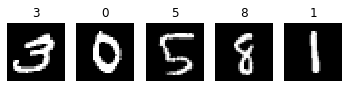

In [7]:
# 実際にランダムな5個の画像を入力し推論APIの動作を確認
%matplotlib inline
import random
import matplotlib.pyplot as plt

num_samples = 5
indices = random.sample(range(x_test.shape[0] - 1), num_samples)
images, labels = x_test[indices]/255, y_test[indices]

for i in range(num_samples):
    plt.subplot(1,num_samples,i+1)
    plt.imshow(images[i].reshape(28, 28), cmap='gray')
    plt.title(labels[i])
    plt.axis('off')
    
prediction = local_predictor.predict(images.reshape(num_samples, 28, 28, 1))['predictions']
prediction = np.array(prediction)
predicted_label = prediction.argmax(axis=1)
print('The predicted labels are: {}'.format(predicted_label))

In [8]:
# Delete endpoint
local_predictor.delete_endpoint()

Gracefully stopping... (press Ctrl+C again to force)


In [9]:
! docker container ls

CONTAINER ID        IMAGE               COMMAND             CREATED             STATUS              PORTS               NAMES


# SageMakerを利用した学習と推論

## GitHubへのpush
手元の環境で少量のデータを用いてコードが問題なく動作するかを確認できたので、コードをGitHubにpushします。commitやpushの過程は省略します。Githubを介さずSageMaker学習や推論を行なうことはもちろん可能ですが、今回はGithubを利用する場合の利用法を記しています。

## 学習用データをS3にアップロード
SageMaker Python SDKのupload_data関数を利用して、S3へデータをアップロードします

In [12]:
from sagemaker import Session
sagemaker_session = Session()
bucket_name = sagemaker_session.default_bucket()
input_data = sagemaker_session.upload_data(path='./data', bucket=bucket_name, key_prefix='dataset/mnist')
print('Training data is uploaded to: {}'.format(input_data))

Training data is uploaded to: s3://sagemaker-ap-northeast-1-219819523389/dataset/mnist


## SageMakerを利用した学習

ローカル環境での学習の際とは異なり、`instance_type`で学習用のインスタンスタイプを指定することで別途SageMakerの学習用インスタンスを起動し学習することができます。学習用インスタンスは学習が終わると自動的に終了するため、大量のデータに対してGPUや多くのCPU・メモリを利用して学習を行う際もコスト効率良く実行することができます。インスタンスタイプの詳細は[こちら](https://aws.amazon.com/jp/sagemaker/pricing/instance-types/)から確認できます。他にも複数ノードによる分散学習については[こちら](https://aws.amazon.com/jp/blogs/news/launching-tensorflow-distributed-training-easily-with-horovod-or-parameter-servers-in-amazon-sagemaker/)をご覧ください。

git_configパラメータを利用することで、GitHubやCodeCommitで管理されたコードを利用し学習・推論を行なうことができます。具体的にはEstimator作成時にgit_configを指定すると、SageMaker Python SDKがGitHub等からソースコードを手元の環境にcloneし、S3へアップロードした後、学習ジョブ実行時にそのS３パスを引き渡します。git_configの詳細は[こちら](https://sagemaker.readthedocs.io/en/stable/overview.html#use-scripts-stored-in-a-git-repository)をご覧ください。git clone部分でエラーが発生する場合、まずはgitのcredential周りをご確認下さい。

roleにはSageMakerの学習用インスタンスが利用するIAM RoleのARNを指定します。詳細は[こちら](https://docs.aws.amazon.com/ja_jp/sagemaker/latest/dg/sagemaker-roles.html#sagemaker-roles-createtrainingjob-perms)を確認下さい。過去にノートブックインスタンスを立ち上げたことがある場合、そのタイミングで作成されたSageMaker用のIAMロールを利用頂いても大丈夫です(サクッと検証したい場合)。

学習が始まると、学習用インスタンスに出力されたログが表示されます。

![図2](./images/image2.jpg "図2")

In [34]:
from sagemaker.tensorflow import TensorFlow
from sagemaker import get_execution_role
from time import gmtime, strftime

commit = "c7522fa"
git_config = {'repo': 'git@github.com:kazuya-iwami/sagemaker-sample.git',
              'branch': 'master',
              'commit': commit}

job_name = "project1-keras-tf-mnist-{}-{}".format(commit, strftime("%Y-%m-%d-%H-%M-%S", gmtime()))

role = 'arn:aws:iam::219819523389:role/service-role/AmazonSageMaker-ExecutionRole-20191127T135552'

estimator = TensorFlow(entry_point = "keras_tf_mnist.py",
          role=role,
          train_instance_count=1,
          train_instance_type="ml.m4.xlarge",
          framework_version="1.14.0",
          py_version='py3',
          script_mode=True,
          git_config=git_config,
          source_dir='project1',
          hyperparameters={'batch-size': 64,
                         'n-class': 10,
                         'epochs': 2})

estimator.fit(inputs=input_data, job_name=job_name) 
latest_training_job_name = estimator.latest_training_job.name
print("job name: {}".format(latest_training_job_name))

2019-12-01 07:52:21 Starting - Starting the training job...
2019-12-01 07:52:22 Starting - Launching requested ML instances......
2019-12-01 07:53:24 Starting - Preparing the instances for training...
2019-12-01 07:54:17 Downloading - Downloading input data...
2019-12-01 07:54:33 Training - Downloading the training image../usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureW

## SageMakerを利用して推論用APIを起動

推論を行うために学習したモデルをデプロイします。`deploy()` メソッドでは、デプロイ先エンドポイントのインスタンス数、インスタンスタイプを指定します。ここではSageMakerの推論用インスタンスを起動し、推論用APIを生成します。

SageMakerでTensorFlowを利用する場合、推論用エンドポイントには[TensorFlow Serving](https://www.tensorflow.org/tfx/guide/serving)が利用されます。推論時に独自の前処理や後処理を実行したい場合は[こちら](https://sagemaker.readthedocs.io/en/stable/using_tf.html#create-python-scripts-for-custom-input-and-output-formats)を参考に推論用のPython Scriptを指定できます。

![図3](./images/image3.jpg "図3")

In [ ]:
predictor = estimator.deploy(initial_instance_count=1,instance_type='ml.m4.xlarge')

The predicted labels are: [7 0 7 9 9]


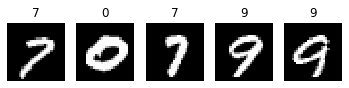

In [25]:
# 実際にランダムな5個の画像を入力し推論APIの動作を確認
%matplotlib inline
import random
import matplotlib.pyplot as plt

num_samples = 5
indices = random.sample(range(x_test.shape[0] - 1), num_samples)
images, labels = x_test[indices]/255, y_test[indices]

for i in range(num_samples):
    plt.subplot(1,num_samples,i+1)
    plt.imshow(images[i].reshape(28, 28), cmap='gray')
    plt.title(labels[i])
    plt.axis('off')
    
prediction = predictor.predict(images.reshape(num_samples, 28, 28, 1))['predictions']
prediction = np.array(prediction)
predicted_label = prediction.argmax(axis=1)
print('The predicted labels are: {}'.format(predicted_label))

In [ ]:
# エンドポイントの削除
predictor.delete_endpoint()

## 補足： 非同期で学習ジョブを実行する例

In [ ]:
estimator.fit(input_data, wait=False) #wait=Falseで非同期実行
latest_training_job_name = estimator.latest_training_job.name
print("job name: {}".format(latest_training_job_name))

In [ ]:
# 学習の進捗確認 
# InProgressがCompletedに変われば学習終了
desc = sagemaker_session.sagemaker_client.describe_training_job(
    TrainingJobName=latest_training_job_name
)
print(desc["TrainingJobStatus"])

In [17]:
# 学習済みモデルのS3パスも確認可能
desc = sagemaker_session.sagemaker_client.describe_training_job(
    TrainingJobName=latest_training_job_name
)
# import pprint
# pprint.pprint(desc)
model_path = desc["ModelArtifacts"]["S3ModelArtifacts"]
print("model is saved in S3: {}".format(model_path))


model is saved in S3: s3://sagemaker-ap-northeast-1-219819523389/tensorflow-training-2019-11-30-15-26-22-334/output/model.tar.gz


In [ ]:
estimator = estimator.attach(training_job_name=latest_training_job_name) 
predictor = estimator.deploy(initial_instance_count=1,instance_type='ml.m4.xlarge')

In [ ]:
# エンドポイントの削除
predictor.delete_endpoint()

## 補足：オンプレミスで学習済みモデルをSageMakerでデプロイする例
1. オンプレミスで学習
1. tf.saved_model.simple_saveでモデルを保存しtarで圧縮
1. S3にアップロード(これをModel Artifactと呼ぶ)
1. 以下を実行

In [20]:
from sagemaker.tensorflow.serving import Model

model_path = "s3://" #Model ArtifactのS3pathを指定
model = Model(
    model_path,
    role,
    sagemaker_session=sagemaker_session,
    framework_version="1.14.0",
)
predictor = estimator.deploy(initial_instance_count=1,instance_type='ml.m4.xlarge')

--------------------------------------------------------------------------------------!

In [26]:
# エンドポイントの削除
predictor.delete_endpoint()

# 運用環境について考える

ここまでは、SageMaker Python SDKを利用して、人がアドホックに学習/推論を行う方法を示しました。
実際の現場では、本番環境に導入する際は定期的に増加したデータで再学習を行い、自動でAPIをアップデートする仕組みが必要となるケースがあります。

Under cons